# Data Loading #

In [1]:
import os
import pandas as pd
import re
import numpy as np
import torch

### Perform Counts on Data ###

In [33]:
datapath = "./Data/variants/"
regex = re.compile('[^a-zA-Z]')

longest_ref = 0
longest_ref_string = ""
longest_alt = 0
longest_alt_string = ""
most_variants = 0
counter = 1
max_variants = 0
largest_pos = 0
smallest_pos = 99999999999999
largest_node = 0
total_files = len(os.listdir(datapath))
for filename in os.listdir(datapath):
    # print("Progress: " + str(counter) + "/" + str(total_files))
    df = pd.read_table(os.path.join(datapath, filename))
    num_variants = 0
    curr_node = -1
    num_variants_total = 0
    for node, pos, ref, alt in zip(df['node_id'], df['POS'], df['REF'], df['ALT']):
        # if node == 1140:
        #     print("aaaaa")
        if node > largest_node:
            largest_node = node
        if node > curr_node:
            num_variants = 0
            curr_node = node

        if pos > largest_pos:
            largest_pos = pos
        if pos < smallest_pos:
            smallest_pos = pos
        ref = regex.sub('', ref)
        alt = regex.sub('', alt)
        if len(ref) > longest_ref:
            longest_ref = len(ref)
            longest_ref_string = ref
        if len(alt) > longest_alt:
            longest_alt = len(alt)
            longest_alt_string = alt

        num_variants += 1
        num_variants_total += 1
        if num_variants > most_variants:
            most_variants = num_variants
        if num_variants_total > max_variants:
            max_variants = num_variants_total
    counter += 1

print("Longest Ref: " + str(longest_ref))
print(longest_ref_string)
print("Longest Alt: " + str(longest_alt))
print(longest_alt_string)
print("Most Variants: " + str(most_variants))
print("Max Variants: " + str(max_variants))
print(largest_pos)
print(smallest_pos)
print(largest_node)

Longest Ref: 226
GTCAATCTCCTGGGCTCCTGGGTTCCGTCTGCCCTGTTCATAGAGACAGAATGAGGGCGTCCCCAGGTGGTGAGCTCAGGGACGTGTGTGTGTGTGTGTGTGTGTGTAACCATCAATCTCCTGGGCTCCTGGGTTCCGTCTGCCCTGTTCATAGGGATGGAATGAGGGCGTCCCCAGGTGGTGAGCTCAGGGACGTTGTGTGTGTGTGTGTGTGTGTGTGTAACCA
Longest Alt: 804
AGTGGTACTTGGTGGTGGTGGTGGTGCTTGGTGATGGTGGTACTTGGTGGTGGTGGTGGTACTTGGTGGTGATGGTACTTGGTGGTGGTGGTACTTGGTGGTGGCAGTGGTACTTGGTGGTGGTACTTGGTGGTACTTGGTGGTGGTGGTGGTACTTGGTGGTGGCGGTGGTACTTGGTGGTGCTGGTGGTGCTTGGTGGTGGTGGTGGTACTTGGTGGTGGTGATGGTACTTGGTGGTGGTGGTGGTGGTACTTGGTGGTGGTACTTGGTGGTACTTGGTGGTGGTGGCGGTACTTGGTGGTGGTGGCGGTGGCACTTGGTGGTGGTGGTGCTTGGTGGTGGTGATGGTACTTGGTGGTGGTGATGGTACTTGGTGGTGGTGGTGGTGGTACTTGGTGGTGAGTGGTACTTGGTGGTGGTGGTGGTGCTTGGTGGTGGTGGTACTTGGTGGTGGTGGTGGTACTTGGTGGTGATGGTACTTGGTGGTGGTGGTACTTGGTGGTGGCAGTGGTACTTGGTGGTGGTACTTGGTGGTACTTGGTGGTGGTGGTGGTACTTGGTGGTGGCGGTGGTACTTGGTGGTGCTGGTGGTGCTTGGTGGTGGTGGTGGTACTTGGTGGTGGTGATGGTACTTGGTGGTGGTGGTGGTGGTACTTGGTGGTGGTACTTGGTGGTACTTGGTGGTGGTGGCGGTACTTGGTGGTGGTGGCGGTGGCACTTGGTGGTGGTGGTGCTTGG

### Generate 1-, 2-, and 3- mer combinations ###
The embedding for a variant will be of size 85; the first element will be the position of the variant normalized using pytorch.normalize with default settings, the next 84 will be the number of occurences of each of the k-mer substrings

In [2]:
bases = ['A', 'C', 'T', 'G']
k_mers = ['A', 'C', 'T', 'G']

for base in bases:
    for base2 in bases:
        k_mers.append(base + base2)

for base in bases:
    for base2 in bases:
        for base3 in bases:
            k_mers.append(base + base2 + base3)

print(len(k_mers))
print(k_mers)

84
['A', 'C', 'T', 'G', 'AA', 'AC', 'AT', 'AG', 'CA', 'CC', 'CT', 'CG', 'TA', 'TC', 'TT', 'TG', 'GA', 'GC', 'GT', 'GG', 'AAA', 'AAC', 'AAT', 'AAG', 'ACA', 'ACC', 'ACT', 'ACG', 'ATA', 'ATC', 'ATT', 'ATG', 'AGA', 'AGC', 'AGT', 'AGG', 'CAA', 'CAC', 'CAT', 'CAG', 'CCA', 'CCC', 'CCT', 'CCG', 'CTA', 'CTC', 'CTT', 'CTG', 'CGA', 'CGC', 'CGT', 'CGG', 'TAA', 'TAC', 'TAT', 'TAG', 'TCA', 'TCC', 'TCT', 'TCG', 'TTA', 'TTC', 'TTT', 'TTG', 'TGA', 'TGC', 'TGT', 'TGG', 'GAA', 'GAC', 'GAT', 'GAG', 'GCA', 'GCC', 'GCT', 'GCG', 'GTA', 'GTC', 'GTT', 'GTG', 'GGA', 'GGC', 'GGT', 'GGG']


# Create dataset for GNN #

Grab adjacency matrix from file

In [3]:
from pandas import isna

datapath = "./Data/graph_structure.tsv"

edge_idx = []
edge_feats = []

df = pd.read_table(datapath)
for node1, node2, score in zip(df["node_A_num"], df["node_B_num"], df['combined_score']):
    if not isna(node1) and not isna(node2) and not (node1 > 1148 or node2 > 1148):
        edge_idx.append([node1, node2])
        edge_feats.append(score)

edge_idx = torch.LongTensor(edge_idx).T
edge_feats = torch.Tensor(edge_feats).unsqueeze(1)
print(edge_idx.shape)
print(edge_feats.shape)

torch.Size([2, 211276])
torch.Size([211276, 1])


Grab labels and assign them categorical integers

In [2]:
from sklearn.preprocessing import LabelEncoder

datapath = "./Data/ethnicities.tsv"

ethnicities = set()
ethnicity_le = LabelEncoder()

df = pd.read_table(datapath)
for eth in df['population_description']:
    ethnicities.add(eth)

ethnicity_le.fit(list(ethnicities))
print(ethnicity_le.classes_)

['African Ancestry in Southwest US' 'African Caribbean in Barbados'
 'Bengali in Bangladesh' 'British in England and Scotland'
 'Chinese Dai in Xishuangbanna, China' 'Colombian in Medellin, Colombia'
 'Esan in Nigeria' 'Finnish in Finland'
 'Gambian in Western Division, The Gambia' 'Gujarati Indian in Houston,TX'
 'Han Chinese in Bejing, China' 'Iberian populations in Spain'
 'Indian Telugu in the UK' 'Japanese in Tokyo, Japan'
 'Kinh in Ho Chi Minh City, Vietnam' 'Luhya in Webuye, Kenya'
 'Mende in Sierra Leone' 'Mexican Ancestry in Los Angeles, California'
 'Peruvian in Lima, Peru' 'Puerto Rican in Puerto Rico'
 'Punjabi in Lahore,Pakistan' 'Southern Han Chinese, China'
 'Sri Lankan Tamil in the UK' 'Toscani in Italy'
 'Utah residents with Northern and Western European ancestry'
 'Yoruba in Ibadan, Nigeria']


In [3]:
import pickle

with open('./pickles/ethset.pkl', 'wb') as fp:
    pickle.dump(ethnicities, fp)
    print("Pickle Successful")

Pickle Successful


Create Dataset

In [5]:
# Largest values in subset of data I'm working with, grabbed from the earlier section "Perform counts on data"
# Used to pad data so that everything is of uniform size
largest_node_id = 1148

In [7]:
from torch_geometric.data import Data
import os

datapath = "./Data/variants/"
datapath_labels = "./Data/ethnicities.tsv"
# This data_list will be used to create our dataset
data_list = []

counter = 1
total_files = len(os.listdir(datapath))
idx = 0
for filename in os.listdir(datapath):
    print("Progress: " + str(counter) + "/" + str(total_files))

    # Create the features for each node
    df = pd.read_table(os.path.join(datapath, filename))
    node_feats = []
    for i in range(largest_node_id + 1):
        curr_node_feats = np.zeros(84)
        node_id_list = df[df["node_id"] == i]
        if len(node_id_list) != 0:
            for alt in node_id_list["ALT"]:
                for i, kmer in enumerate(k_mers):
                    curr_node_feats[i] += alt.count(kmer)
            
        node_feats.append(curr_node_feats)  

    node_feats = torch.from_numpy(np.array(node_feats))
    # print(node_feats.shape)


    # Get label for this file
    id = filename.split(".")[0]
    df = pd.read_table(datapath_labels)
    label_entry = df[df["sample_id"] == id]
    if len(label_entry) == 0:
        print("ERROR")
        print(id)
    
    label_int = ethnicity_le.transform(label_entry["population_description"])
    label_int = torch.Tensor(label_int)


    # Create a Data object, add it to the list
    new_entry = Data()

    new_entry.x = node_feats
    new_entry.edge_index = edge_idx
    new_entry.edge_attr = edge_feats
    new_entry.y = label_int

    data_list.append(new_entry)

    counter += 1

Progress: 1/116
Progress: 2/116
Progress: 3/116
Progress: 4/116
Progress: 5/116
Progress: 6/116
Progress: 7/116
Progress: 8/116
Progress: 9/116
Progress: 10/116
Progress: 11/116
Progress: 12/116
Progress: 13/116
Progress: 14/116
Progress: 15/116
Progress: 16/116
Progress: 17/116
Progress: 18/116
Progress: 19/116
Progress: 20/116
Progress: 21/116
Progress: 22/116
Progress: 23/116
Progress: 24/116
Progress: 25/116
Progress: 26/116
Progress: 27/116
Progress: 28/116
Progress: 29/116
Progress: 30/116
Progress: 31/116
Progress: 32/116
Progress: 33/116
Progress: 34/116
Progress: 35/116
Progress: 36/116
Progress: 37/116
Progress: 38/116
Progress: 39/116
Progress: 40/116
Progress: 41/116
Progress: 42/116
Progress: 43/116
Progress: 44/116
Progress: 45/116
Progress: 46/116
Progress: 47/116
Progress: 48/116
Progress: 49/116
Progress: 50/116
Progress: 51/116
Progress: 52/116
Progress: 53/116
Progress: 54/116
Progress: 55/116
Progress: 56/116
Progress: 57/116
Progress: 58/116
Progress: 59/116
Progre

In [33]:
import pickle

with open('./pickles/datalist.pkl', 'wb') as fp:
    pickle.dump(data_list, fp)
    print("Pickle Successful")

Pickle Successful


In [1]:
import pickle

with open('./pickles/datalist.pkl', 'rb') as fp:
    data_list = pickle.load(fp)
    print("Pickle loaded")

Pickle loaded


In [13]:
print(data_list[0].edge_attr.shape)

torch.Size([211276, 1])


# Graph Neural Network Classifier #

In [127]:
import os
import torch
from torchmetrics.classification import MulticlassAUROC
from torch_geometric.loader import DataLoader
from IPython.display import Javascript
from sklearn.preprocessing import LabelEncoder
import pickle

In [128]:
with open('./pickles/datalist.pkl', 'rb') as fp:
    data_list = pickle.load(fp)
    print("Pickle loaded")

with open('./pickles/ethset.pkl', 'rb') as fp:
    ethnicities = pickle.load(fp)
    print("Pickle loaded")

Pickle loaded
Pickle loaded


In [129]:
ethnicity_le = LabelEncoder()

ethnicity_le.fit(list(ethnicities))

LabelEncoder()

In [130]:
print(torch.cuda.is_available())
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

True


In [131]:
split = int(len(data_list) * 0.8)

train_list = data_list[:split]
test_list = data_list[split:]

In [132]:
batch_size=8
train_loader = DataLoader(train_list, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_list, batch_size=batch_size, shuffle=False)

for step, data in enumerate(train_loader):
    print(f'Step {step + 1}:')
    print('=======')
    print(f'Number of graphs in the current batch: {data.num_graphs}')
    print(data)

for step, data in enumerate(test_loader):
    print(f'Step {step + 1}:')
    print('=======')
    print(f'Number of graphs in the current batch: {data.num_graphs}')
    print(data)

Step 1:
Number of graphs in the current batch: 8
DataBatch(x=[9192, 84], edge_index=[2, 1690208], edge_attr=[1690208, 1], y=[8], batch=[9192], ptr=[9])
Step 2:
Number of graphs in the current batch: 8
DataBatch(x=[9192, 84], edge_index=[2, 1690208], edge_attr=[1690208, 1], y=[8], batch=[9192], ptr=[9])
Step 3:
Number of graphs in the current batch: 8
DataBatch(x=[9192, 84], edge_index=[2, 1690208], edge_attr=[1690208, 1], y=[8], batch=[9192], ptr=[9])
Step 4:
Number of graphs in the current batch: 8
DataBatch(x=[9192, 84], edge_index=[2, 1690208], edge_attr=[1690208, 1], y=[8], batch=[9192], ptr=[9])
Step 5:
Number of graphs in the current batch: 8
DataBatch(x=[9192, 84], edge_index=[2, 1690208], edge_attr=[1690208, 1], y=[8], batch=[9192], ptr=[9])
Step 6:
Number of graphs in the current batch: 8
DataBatch(x=[9192, 84], edge_index=[2, 1690208], edge_attr=[1690208, 1], y=[8], batch=[9192], ptr=[9])
Step 7:
Number of graphs in the current batch: 8
DataBatch(x=[9192, 84], edge_index=[2, 

In [133]:
from model.GraphConvNet import GNN

model = GNN(84, 64, 32, 16, len(ethnicity_le.classes_)).to(device)
print(model)

learning_rate = 1e-3
epoch_num = 10
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
loss_fn = torch.nn.CrossEntropyLoss()

GNN(
  (conv1): GraphConv(84, 64)
  (conv2): GraphConv(64, 32)
  (conv3): GraphConv(32, 16)
  (fc1): Linear(in_features=16, out_features=26, bias=True)
)


In [134]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    print(size)
    model.train()
    total_loss = 0.0
    current = 0
    for i, data in enumerate(dataloader):  # Iterate in batches over the training dataset.
        out = model(data.x.to(torch.float32).to(device), data.edge_index.to(device), data.batch.to(device))  # Perform a single forward pass.

        loss = loss_fn(out, data.y.type(torch.LongTensor).to(device))  # Compute the loss.
        total_loss += loss
        loss.backward()  # Derive gradients.
        optimizer.step()  # Update parameters based on gradients.
        optimizer.zero_grad()  # Clear gradients.


        loss = loss.item()
        current += data.y.shape[0]
        if i % 4 == 0:
            print(f"loss: {loss:>.7f}  [{current:>5d}/{size:>5d}]")

In [135]:
total_loss = []
accuracy_over_time = []
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for data in dataloader:
            out = model(data.x.to(torch.float32).to(device), data.edge_index.to(device), data.batch.to(device))
            loss = loss_fn(out, data.y.type(torch.LongTensor).to(device))
            test_loss += loss
            # print(out.shape)
            # print(out.argmax(1))
            # print(data.y)
            correct += (out.argmax(1) == data.y.type(torch.LongTensor).to(device)).type(torch.float).sum().item()
    test_loss /= num_batches
    total_loss.append(test_loss.cpu())
    correct /= size
    accuracy_over_time.append(100*correct)
    print(f"Valid Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [136]:
epochs = 100
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_loader, model, loss_fn, optimizer)
    test(test_loader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
92
loss: 5282378.0000000  [    8/   92]
loss: 1148638.8750000  [   40/   92]
loss: 920479.0000000  [   72/   92]
Valid Error: 
 Accuracy: 0.0%, Avg loss: 395665.093750 

Epoch 2
-------------------------------
92
loss: 607989.2500000  [    8/   92]
loss: 394154.8437500  [   40/   92]
loss: 198479.1406250  [   72/   92]
Valid Error: 
 Accuracy: 4.2%, Avg loss: 373820.312500 

Epoch 3
-------------------------------
92
loss: 200022.2500000  [    8/   92]
loss: 107486.0078125  [   40/   92]
loss: 225458.5312500  [   72/   92]
Valid Error: 
 Accuracy: 0.0%, Avg loss: 46474.496094 

Epoch 4
-------------------------------
92
loss: 52747.1796875  [    8/   92]
loss: 29839.2343750  [   40/   92]
loss: 30128.3046875  [   72/   92]
Valid Error: 
 Accuracy: 0.0%, Avg loss: 3861.958496 

Epoch 5
-------------------------------
92
loss: 25106.6308594  [    8/   92]
loss: 8274.6640625  [   40/   92]
loss: 11995.3320312  [   72/   92]
Valid Error: 
 Accuracy: 

[tensor(395665.0938), tensor(373820.3125), tensor(46474.4961), tensor(3861.9585), tensor(3.6624), tensor(4.0510), tensor(4.2311), tensor(4.1222), tensor(4.8311), tensor(4.2981), tensor(2.7395), tensor(4.6748), tensor(7.0642), tensor(10.5761), tensor(8.8334), tensor(7.6004), tensor(7.1791), tensor(5.9797), tensor(6.4841), tensor(6.6591), tensor(5.9193), tensor(6.8513), tensor(6.6247), tensor(4.8916), tensor(4.5437), tensor(5.1728), tensor(5.1711), tensor(4.4433), tensor(4.2009), tensor(4.2485), tensor(4.8642), tensor(5.3240), tensor(7.3568), tensor(5.9815), tensor(6.0610), tensor(4.8192), tensor(3.7285), tensor(4.5458), tensor(5.0301), tensor(3.8303), tensor(3.6292), tensor(3.3494), tensor(2.9677), tensor(3.0668), tensor(2.7210), tensor(2.9013), tensor(3.4768), tensor(3.3831), tensor(3.0249), tensor(3.0266), tensor(3.1216), tensor(2.9079), tensor(3.5969), tensor(3.6077), tensor(2.4897), tensor(2.3423), tensor(2.4416), tensor(2.7346), tensor(2.6770), tensor(2.3747), tensor(2.3797), tenso

[Text(0.5, 0, 'Epochs'), Text(0, 0.5, 'Accuracy')]

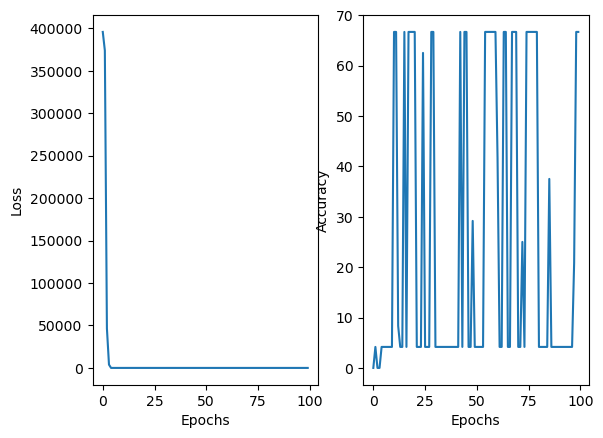

In [138]:
import matplotlib.pyplot as plt

figure, axis = plt.subplots(1, 2)
num_epochs = range(100)
print(total_loss)

axis[0].plot(num_epochs, total_loss)
axis[0].set(xlabel="Epochs", ylabel='Loss')

axis[1].plot(num_epochs, accuracy_over_time)
axis[1].set(xlabel="Epochs", ylabel='Accuracy')